# Regression modeling
<br>
**The goal** is to build a logistic regression model and evaluate the model.
<br/>
This activity has three parts:

**Part 1:**  Imports, links, and loading
<br>
**Part 2:**  EDA & Checking Model Assumptions
<br>
**Part 3:**  Model Building and Evaluation
<br>
**Part 4:**  Interpreting Model Results
<br>

### PACE: Plan

**Part 1:** Imports, links, and loading

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import resample

# Import packages for data modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Suppress specific FutureWarnings from Seaborn
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")

### PACE: Analyze

**Part 2:**  EDA & Checking Model Assumptions

In [2]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [3]:
# Drop rows with missing values
data = data.dropna(axis=0)

In [4]:
# Display first few rows after handling missing values
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [5]:
# Check for duplicates
data.duplicated().sum()

0

There does not seem to be any duplicates

In [6]:
# Check for and handle outliers

percentile25 = data["video_like_count"].quantile(0.25)
percentile75 = data["video_like_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_like_count"] > upper_limit, "video_like_count"] = upper_limit

In [7]:
# Check for and handle outliers

percentile25 = data["video_comment_count"].quantile(0.25)
percentile75 = data["video_comment_count"].quantile(0.75)

iqr = percentile75 - percentile25
upper_limit = percentile75 + 1.5 * iqr

data.loc[data["video_comment_count"] > upper_limit, "video_comment_count"] = upper_limit

Check class balance of the target variable. Remember, the goal is to predict whether the user of a given post is verified or unverified.

In [8]:
# Check class balance
data["verified_status"].value_counts(normalize=True)

verified_status
not verified    0.93712
verified        0.06288
Name: proportion, dtype: float64

Approximately 93.7% of the dataset represents videos posted by unverified accounts and 6.3% represents videos posted by verified accounts. So the outcome variable is not very balanced.

Use resampling to create class balance in the outcome variable, if needed.

In [10]:
# Use resampling to create class balance in the outcome variable, if needed

# Identify data points from majority and minority classes
data_majority = data[data["verified_status"] == "not verified"]
data_minority = data[data["verified_status"] == "verified"]

# Upsample the minority class (which is "verified")
data_minority_upsampled = resample(data_minority,
                                 replace=True,                 # to sample with replacement
                                 n_samples=len(data_majority), # to match majority class
                                 random_state=0)               # to create reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled]).reset_index(drop=True)

# Display new class counts
data_upsampled["verified_status"].value_counts()

verified_status
not verified    17884
verified        17884
Name: count, dtype: int64

Get the average `video_transcription_text` length for videos posted by verified accounts and the average `video_transcription_text` length for videos posted by unverified accounts.



In [11]:
# Get the average `video_transcription_text` length for claims and the average `video_transcription_text` length for opinions
data_upsampled[["verified_status", "video_transcription_text"]].groupby(by="verified_status")[["video_transcription_text"]].agg(func=lambda array: np.mean([len(text) for text in array]))

,video_transcription_text
verified_status,
not verified,89.401141
verified,84.569559


Extract the length of each `video_transcription_text` and add this as a column to the dataframe, so that it can be used as a potential feature in the model.

In [12]:
# Extract the length of each `video_transcription_text` and add this as a column to the dataframe
data_upsampled["text_length"] = data_upsampled["video_transcription_text"].apply(func=lambda text: len(text))

In [13]:
# Display first few rows of dataframe after adding new column
data_upsampled.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts.

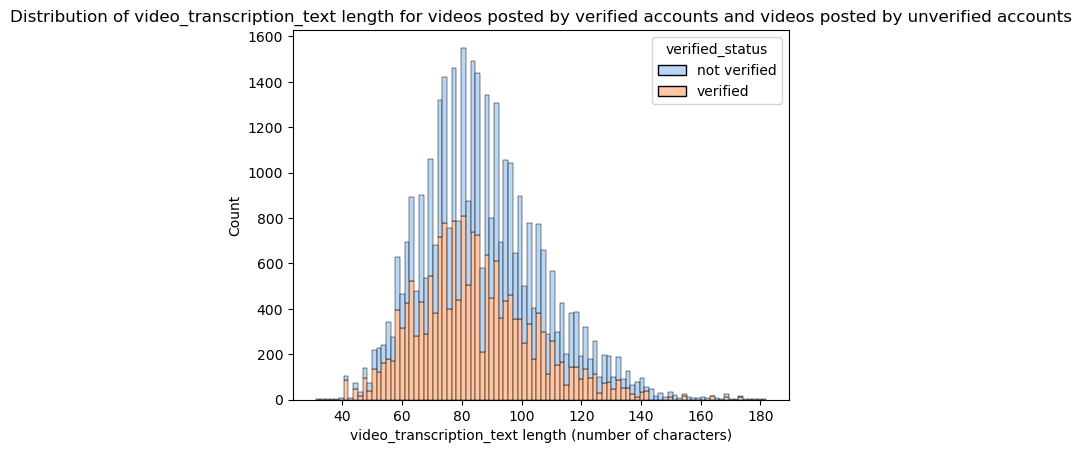

In [14]:
# Visualize the distribution of `video_transcription_text` length for videos posted by verified accounts and videos posted by unverified accounts
# Create two histograms in one plot
sns.histplot(data=data_upsampled, stat="count", multiple="stack", x="text_length", kde=False, palette="pastel", 
             hue="verified_status", element="bars", legend=True)
plt.title("Seaborn Stacked Histogram")
plt.xlabel("video_transcription_text length (number of characters)")
plt.ylabel("Count")
plt.title("Distribution of video_transcription_text length for videos posted by verified accounts and videos posted by unverified accounts")
plt.show()

Create a correlation matrix to help determine most correlated variables.

In [15]:
# correlation matrix to help determine most correlated variables
data_upsampled.corr(numeric_only=True)

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
#,1.000000,-0.000853,-0.011729,-0.697007,-0.626385,-0.504015,-0.487096,-0.608773,-0.193677
video_id,-0.000853,1.000000,0.011859,0.002554,0.005993,0.010515,0.008753,0.012674,-0.007083
video_duration_sec,-0.011729,0.011859,1.000000,0.013589,0.004494,0.002206,0.003989,-0.001086,-0.002981
video_view_count,-0.697007,0.002554,0.013589,1.000000,0.856937,0.711313,0.690048,0.748361,0.244693
video_like_count,-0.626385,0.005993,0.004494,0.856937,1.000000,0.832146,0.805543,0.818032,0.216693
video_share_count,-0.504015,0.010515,0.002206,0.711313,0.832146,1.000000,0.710117,0.671335,0.171651
video_download_count,-0.487096,0.008753,0.003989,0.690048,0.805543,0.710117,1.000000,0.793668,0.173396
video_comment_count,-0.608773,0.012674,-0.001086,0.748361,0.818032,0.671335,0.793668,1.000000,0.217661
text_length,-0.193677,-0.007083,-0.002981,0.244693,0.216693,0.171651,0.173396,0.217661,1.000000


Visualize a correlation heatmap of the data.

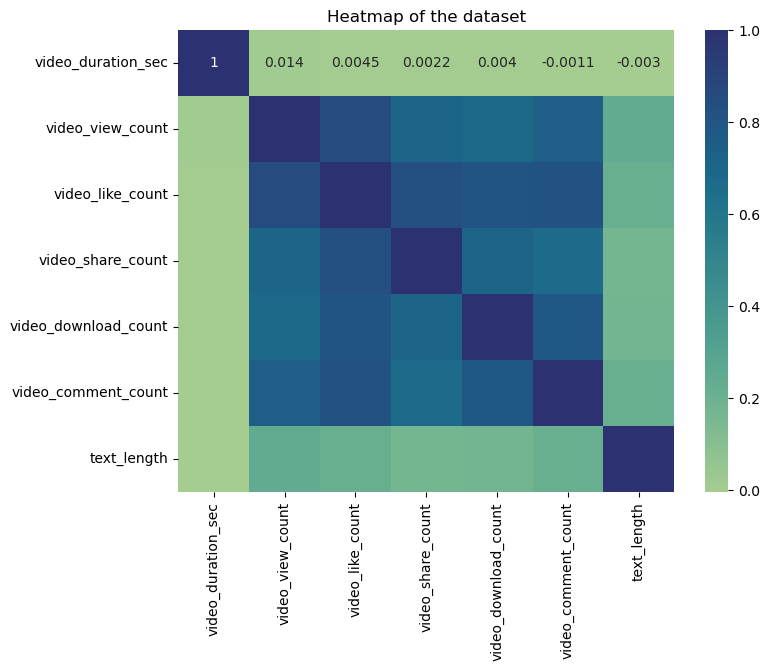

In [16]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count", "text_length"]]
    .corr(numeric_only=True), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

The aheatmap shows that the following pair of variables are strongly correlated: `video_view_count` and `video_like_count` (0.86 correlation coefficient).

One of the model assumptions for logistic regression is no severe multicollinearity among the features. To build a logistic regression model that meets this assumption, exclude `video_like_count`. And among the variables that quantify video metrics, keep `video_view_count`, `video_share_count`, `video_download_count`, and `video_comment_count` as features.

### PACE: Construct

**Part 3:**  Model Building and Evaluation

**Set Y and X variables**

In [17]:
# Select outcome variable
y = data_upsampled["verified_status"]

In [18]:
# Select features
X = data_upsampled[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", "video_share_count", "video_download_count", "video_comment_count"]]

# Display first few rows of features dataframe
X.head()

,video_duration_sec,claim_status,author_ban_status,video_view_count,video_share_count,video_download_count,video_comment_count
0,59,claim,under review,343296.0,241.0,1.0,0.0
1,32,claim,active,140877.0,19034.0,1161.0,684.0
2,31,claim,active,902185.0,2858.0,833.0,329.0
3,25,claim,active,437506.0,34812.0,1234.0,584.0
4,19,claim,active,56167.0,4110.0,547.0,152.0


The `#` and `video_id` columns are not selected as features here, because they do not seem to be helpful for predicting whether a video presents a claim or an opinion. Also, `video_like_count` is not selected as a feature here, because it is strongly correlated with other features, as discussed earlier. And logistic regression has a no multicollinearity model assumption that needs to be met.

Split the data into training and testing sets.

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

Confirm that the dimensions of the training and testing sets are in alignment.

In [20]:
# Get shape of each training and testing set
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26826, 7), (8942, 7), (26826,), (8942,))

**Observation:**
- The number of features (`7`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`26826`) and testing (`8942`).

**Encode variables**

Check the data types of the features.

In [21]:
# Check data types
X_train.dtypes

video_duration_sec        int64
claim_status             object
author_ban_status        object
video_view_count        float64
video_share_count       float64
video_download_count    float64
video_comment_count     float64
dtype: object

In [22]:
# Get unique values in `claim_status`
X_train["claim_status"].unique()

array(['opinion', 'claim'], dtype=object)

In [23]:
# Get unique values in `author_ban_status`
X_train["author_ban_status"].unique()

array(['active', 'under review', 'banned'], dtype=object)

`claim_status` and `author_ban_status` features are each of data type `object` currently. In order to work with the implementations of models through `sklearn`, these categorical features will need to be made numeric. One way to do this is through one-hot encoding.

Encode categorical features in the training set using an appropriate method.

In [27]:
# Select the training features that needs to be encoded
X_train_to_encode = X_train[["claim_status", "author_ban_status"]]

# Display first few rows
X_train_to_encode.head()

,claim_status,author_ban_status
33058,opinion,active
20491,opinion,active
25583,opinion,active
18474,opinion,active
27312,opinion,active


In [28]:
# Set up an encoder for one-hot encoding the categorical features
X_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [29]:
# Fit and transform the training features using the encoder
X_train_encoded = X_encoder.fit_transform(X_train_to_encode)

In [30]:
# Get feature names from encoder
X_encoder.get_feature_names_out()

array(['claim_status_opinion', 'author_ban_status_banned',
       'author_ban_status_under review'], dtype=object)

In [31]:
# Display first few rows of encoded training features
X_train_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [32]:
# Place encoded training features (which is currently an array) into a dataframe
X_train_encoded_df = pd.DataFrame(data=X_train_encoded, columns=X_encoder.get_feature_names_out())

# Display first few rows
X_train_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [33]:
# Display first few rows of `X_train` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_train.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
33058,33,2252.0,23.0,4.0,0.0
20491,52,6664.0,550.0,53.0,2.0
25583,37,6327.0,257.0,3.0,0.0
18474,57,1702.0,28.0,0.0,0.0
27312,21,3842.0,101.0,1.0,0.0


In [34]:
# Concatenate `X_train` and `X_train_encoded_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `claim_status` and `author_ban_status`,
# so that the indices align with those in `X_train_encoded_df` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_train_encoded_df], axis=1)

# Display first few rows
X_train_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,33,2252.0,23.0,4.0,0.0,1.0,0.0,0.0
1,52,6664.0,550.0,53.0,2.0,1.0,0.0,0.0
2,37,6327.0,257.0,3.0,0.0,1.0,0.0,0.0
3,57,1702.0,28.0,0.0,0.0,1.0,0.0,0.0
4,21,3842.0,101.0,1.0,0.0,1.0,0.0,0.0


Check the data type of the outcome variable.

In [35]:
# Check data type of outcome variable
y_train.dtype

dtype('O')

In [36]:
# Get unique values of outcome variable
y_train.unique()

array(['verified', 'not verified'], dtype=object)

A shown above, the outcome variable is of data type `object` currently. One-hot encoding can be used to make this variable numeric.

Encode categorical values of the outcome variable the training set using an appropriate method.

In [37]:
# Set up an encoder for one-hot encoding the categorical outcome variable
y_encoder = OneHotEncoder(drop='first', sparse_output=False)

In [38]:
# Encode the training outcome variable
# Notes:
#   - Adjusting the shape of `y_train` before passing into `.fit_transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.fit_transform()`, so that it can be used later to train the model
y_train_final = y_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Display the encoded training outcome variable
y_train_final

array([1., 1., 1., ..., 1., 1., 0.])

**Part 3:**  Model Building and Evaluation

Construct a model and fit it to the training set.

In [39]:
# Construct a logistic regression model and fit it to the training set
log_clf = LogisticRegression(random_state=0, max_iter=800).fit(X_train_final, y_train_final)

### PACE: Execute

**Part 4:** Results and evaluation

Encode categorical features in the testing set using an appropriate method.

In [40]:
# Select the testing features that needs to be encoded
X_test_to_encode = X_test[["claim_status", "author_ban_status"]]

# Display first few rows
X_test_to_encode.head()

,claim_status,author_ban_status
21061,opinion,active
31748,opinion,active
20197,claim,active
5727,claim,active
11607,opinion,active


In [41]:
# Transform the testing features using the encoder
X_test_encoded = X_encoder.transform(X_test_to_encode)

# Display first few rows of encoded testing features
X_test_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [42]:
# Place encoded testing features (which is currently an array) into a dataframe
X_test_encoded_df = pd.DataFrame(data=X_test_encoded, columns=X_encoder.get_feature_names_out())

# Display first few rows
X_test_encoded_df.head()

,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,1.0,0.0,0.0


In [43]:
# Display first few rows of `X_test` with `claim_status` and `author_ban_status` columns dropped (since these features are being transformed to numeric)
X_test.drop(columns=["claim_status", "author_ban_status"]).head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count
21061,41,2118.0,57.0,5.0,2.0
31748,27,5701.0,157.0,1.0,0.0
20197,31,449767.0,75385.0,5956.0,728.5
5727,19,792813.0,56597.0,5146.0,728.5
11607,54,2044.0,68.0,19.0,2.0


In [44]:
# Concatenate `X_test` and `X_test_encoded_df` to form the final dataframe for training data (`X_test_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_test after dropping `claim_status`, and `author_ban_status`,
# so that the indices align with those in `X_test_encoded_df` and `test_count_df`
X_test_final = pd.concat([X_test.drop(columns=["claim_status", "author_ban_status"]).reset_index(drop=True), X_test_encoded_df], axis=1)

# Display first few rows
X_test_final.head()

,video_duration_sec,video_view_count,video_share_count,video_download_count,video_comment_count,claim_status_opinion,author_ban_status_banned,author_ban_status_under review
0,41,2118.0,57.0,5.0,2.0,1.0,0.0,0.0
1,27,5701.0,157.0,1.0,0.0,1.0,0.0,0.0
2,31,449767.0,75385.0,5956.0,728.5,0.0,0.0,0.0
3,19,792813.0,56597.0,5146.0,728.5,0.0,0.0,0.0
4,54,2044.0,68.0,19.0,2.0,1.0,0.0,0.0


Test the logistic regression model. Use the model to make predictions on the encoded testing set.

In [45]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_clf.predict(X_test_final)

Display the predictions on the encoded testing set.

In [46]:
# Display the predictions on the encoded testing set
y_pred

array([1., 1., 0., ..., 1., 0., 1.])

Display the true labels of the testing set.

In [47]:
# Display the true labels of the testing set
y_test

21061        verified
31748        verified
20197        verified
5727     not verified
11607    not verified
             ...     
14756    not verified
26564        verified
14800    not verified
35705        verified
31060        verified
Name: verified_status, Length: 8942, dtype: object

Encode the true labels of the testing set so it can be compared to the predictions.

In [48]:
# Encode the testing outcome variable
# Notes:
#   - Adjusting the shape of `y_test` before passing into `.transform()`, since it takes in 2D array
#   - Using `.ravel()` to flatten the array returned by `.transform()`, so that it can be used later to compare with predictions
y_test_final = y_encoder.transform(y_test.values.reshape(-1, 1)).ravel()

# Display the encoded testing outcome variable
y_test_final

array([1., 1., 1., ..., 0., 1., 1.])

Confirm again that the dimensions of the training and testing sets are in alignment since additional features were added.

In [49]:
# Get shape of each training and testing set
X_train_final.shape, y_train_final.shape, X_test_final.shape, y_test_final.shape

((26826, 8), (26826,), (8942, 8), (8942,))

**Observation:** 

- The number of features (`8`) aligns between the training and testing sets.
- The number of rows aligns between the features and the outcome variable for training (`26826`) and testing (`8942`).

**Visualize model results**

Create a confusion matrix to visualize the results of the logistic regression model.

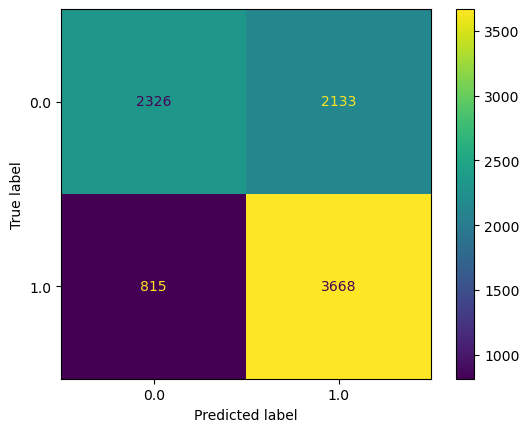

In [50]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test_final, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

In [51]:
(3758+2044) / (3758 + 725 + 2044 + 2415)

0.6488481324088571

**Observation:**

The upper-left quadrant displays the number of true negatives: the number of videos posted by unverified accounts that the model accurately classified as so.

The upper-right quadrant displays the number of false positives: the number of videos posted by unverified accounts that the model misclassified as posted by verified accounts.

The lower-left quadrant displays the number of false negatives: the number of videos posted by verified accounts that the model misclassified as posted by unverified accounts.

The lower-right quadrant displays the number of true positives: the number of videos posted by verified accounts that the model accurately classified as so.

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

In [52]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test_final, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.74      0.52      0.61      4459
not verified       0.63      0.82      0.71      4483

    accuracy                           0.67      8942
   macro avg       0.69      0.67      0.66      8942
weighted avg       0.69      0.67      0.66      8942



**Observation:** The classification report above shows that the logistic regression model achieved a precision of 61% and a recall of 84%, and it achieved an accuracy of 65%. Note that the precision and recall scores are taken from the "not verified" row of the output because that is the target class that we are most interested in predicting. The "verified" class has its own precision/recall metrics, and the weighted average represents the combined metrics for both classes of the target variable.

**Interpret model coefficients**

In [53]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
pd.DataFrame(data={"Feature Name":log_clf.feature_names_in_, "Model Coefficient":log_clf.coef_[0]})

,Feature Name,Model Coefficient
0,video_duration_sec,-2.453804e-03
1,video_view_count,-1.688530e-07
2,video_share_count,4.826067e-06
3,video_download_count,-8.108661e-05
4,video_comment_count,4.482877e-04
5,claim_status_opinion,1.702598e+00
6,author_ban_status_banned,-4.484288e-01
7,author_ban_status_under review,-9.867049e-02


**Task Conclusion**
 The dataset has a few strongly correlated variables, which might lead to multicollinearity issues when fitting a logistic regression model. We decided to drop `video_like_count` from the model building.
- Based on the logistic regression model, each additional second of the video is associated with 0.009 increase in the log-odds of the user having a verified status.
- The logistic regression model had not great, but acceptable predictive power: a precision of 61% is less than ideal, but a recall of 84% is very good. Overall accuracy is towards the lower end of what would typically be considered acceptable. 